In [25]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [4]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [5]:
X,y  = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


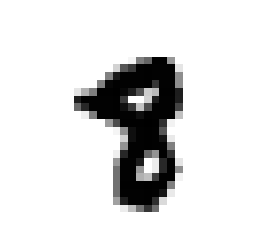

In [6]:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
some_digit = X[50006]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Note that the training set is split where the first 60k images is the test set and the last 10k are test set.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Attempt to crate a one vs all 5 binary classfier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

In [21]:
from sklearn.linear_model import SGDClassifier

skfolds = StratifiedKFold(n_splits=3,random_state=42)
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct)

/Users/adacoope1/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


19125
19290
19340


In [22]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-298560.65882519]


In [23]:
threshold = 0
y_some_digit_pred = (y_scores < threshold)
print(y_some_digit_pred)

[ True]


In [28]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
print(y_scores)

[[      0.         -611839.54453356]
 [      0.         -184573.88649547]
 [      0.         -728184.75023109]
 ..., 
 [      0.         -306561.13778956]
 [      0.         -382400.42057206]
 [      0.         -572318.13160544]]


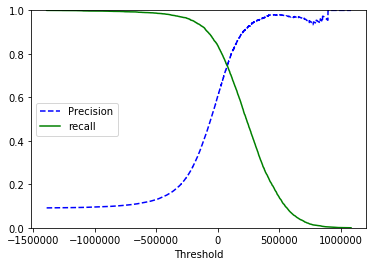

In [29]:
from sklearn.metrics import precision_recall_curve 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

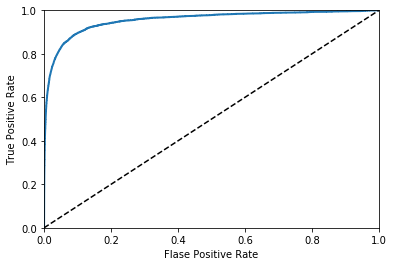

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('Flase Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
    

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores[:,1])

0.95531236114913842

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

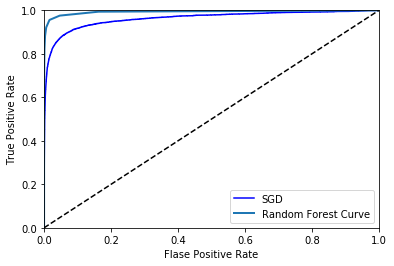

0.993105499111


In [115]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr, "b", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest Curve")
plt.legend(loc="lower right")
plt.show()
print(roc_auc_score(y_train_5,y_scores_forest))

Now one-v-all and one-v-one classification implementations

In [33]:
sgd_clf.fit(X_train,y_train)

print(sgd_clf.classes_)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


In [34]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)

/Users/adacoope1/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          n_jobs=1)

In [35]:
forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print(cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy"))

[ 0.87137572  0.86789339  0.86592989]
[ 0.94016197  0.94104705  0.94284143]


In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([ 0.91021796,  0.9099955 ,  0.91158674])

Some Error Analysis

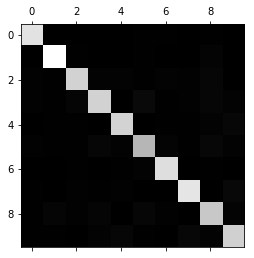

In [40]:
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

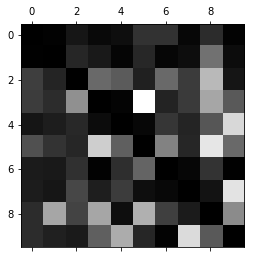

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

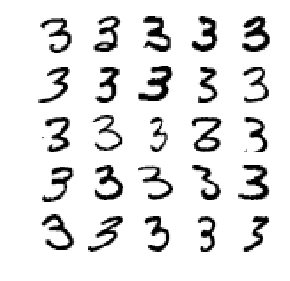

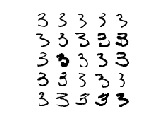

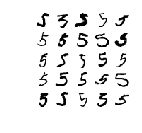

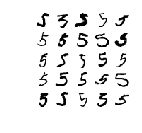

In [42]:
def plot_digits(instances, images_per_row=10):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary)
    plt.axis("off")

a, b = 3, 5
X_aa = X_train[(y_train == a) & (y_train_pred == a)]
X_ab = X_train[(y_train == a) & (y_train_pred == b)]
X_ba = X_train[(y_train == b) & (y_train_pred == a)]
X_bb = X_train[(y_train == b) & (y_train_pred == a)]

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.show()
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.show()
plt.subplot(223)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()
plt.subplot(224)
plot_digits(X_ba[:25], images_per_row=5)
plt.show()

In [43]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
y_train_knn_pre = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pre, average="macro"))